In [1]:
import gpxpy
import mplleaflet
import pykalman
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

%load_ext autoreload
%autoreload 2

# Reading a GPX file

In [35]:
from helpers import *
gpx_files = list_gpx_files()
gpx_file = load_gpx_file(gpx_files, 2)

In [8]:
print("File has {} track(s).".format(len(gpx_file.tracks)))

File has 1 track(s).


In [9]:
print("Track has {} segment(s).".format(len(gpx_file.tracks[0].segments)))

Track has 1 segment(s).


## GPX segments can be easily converted to a Pandas dataframe

In [10]:
segment = gpx_file.tracks[0].segments[0]
coords = pd.DataFrame([{'lat': p.latitude, 
                        'lon': p.longitude, 
                        'ele': p.elevation,
                        'time': p.time} for p in segment.points])
coords.set_index('time', drop=True, inplace=True)
coords.head()

,lat,lon,ele
time,,,
2023-05-28 03:34:21+00:00,41.138656,29.028546,109.800003
2023-05-28 03:34:27+00:00,41.138534,29.028598,109.400002
2023-05-28 03:34:30+00:00,41.138471,29.028636,108.800003
2023-05-28 03:34:31+00:00,41.138453,29.028650,108.800003
2023-05-28 03:34:33+00:00,41.138388,29.028685,108.199997


## Plotting a segment

Text(0.5, 1.0, 'Track')

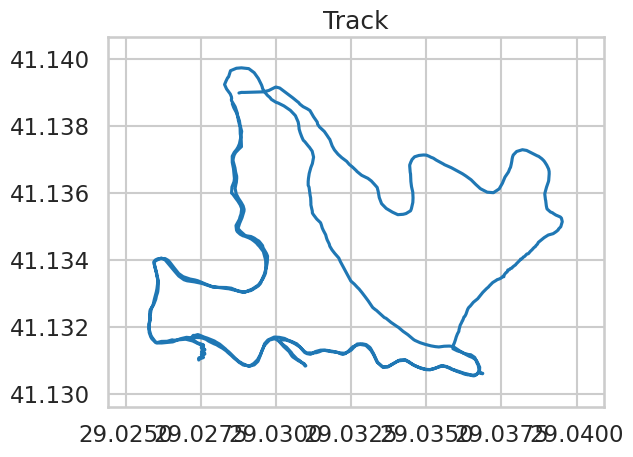

In [11]:
plt.plot(coords['lon'].values, coords['lat'].values)
plt.title("Track")

## Working with the elevation of a track

In [19]:
coords.index = coords.index.tz_localize(None)

<Axes: title={'center': 'Elevation'}, xlabel='time'>

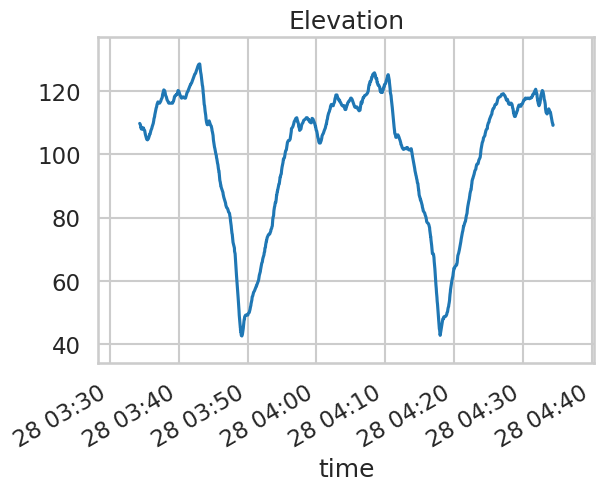

In [21]:
coords.ele.plot(title='Elevation')

### Let's assume the elevation data is missing

In [22]:
for point in segment.points:
    point.elevation = None

### Use srtm.py to add missing elevation data

In [23]:
import srtm

elevation_data = srtm.get_data()
elevation_data.add_elevations(gpx_file, smooth=True)

Creating /home/dg/.cache/srtm
4 2884802


In [24]:
coords['new_ele'] = [p.elevation for p in gpx_file.tracks[0].segments[0].points]

<Axes: title={'center': 'Elevation'}, xlabel='time'>

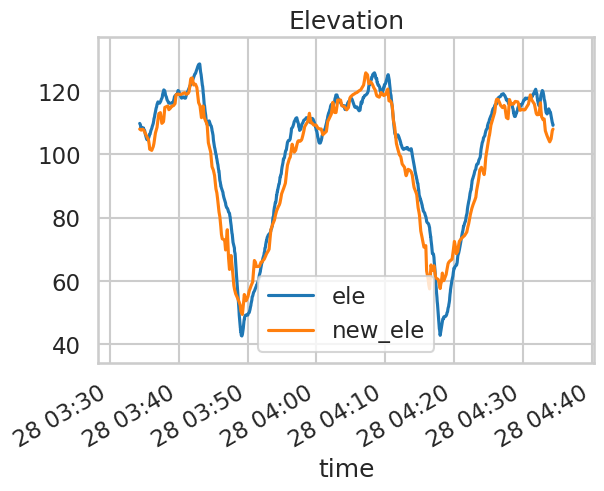

In [25]:
coords[['ele','new_ele']].plot(title='Elevation')

## Working with speeds

In [26]:
start_time, end_time = segment.get_time_bounds()
duration = end_time - start_time

In [27]:
average_speed = segment.length_3d() / duration.seconds * 3.6
print("Average speed is {:.2f} km/h".format(average_speed))

Average speed is 9.04 km/h


### Speed at specific points

In [28]:
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

<Axes: xlabel='time'>

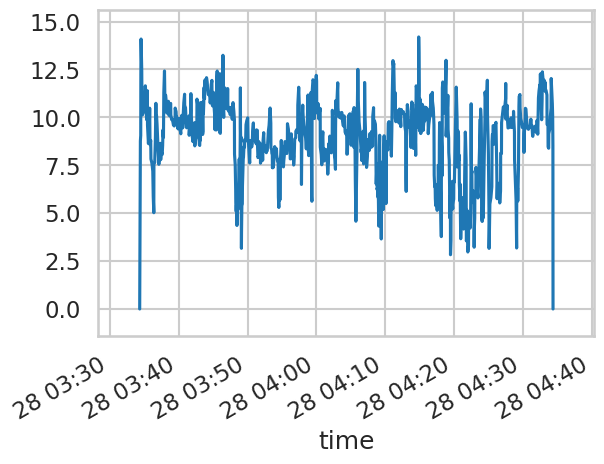

In [29]:
coords['speed'] = [p.speed for p in segment.points]
coords['speed'] *= 3.6
coords['speed'].plot()

In [30]:
coords['speed'].max()

14.197148286616246

### Huiii, up to 235 km/h, that's fast for bikecycle

## What about uphill and downhill distances?

In [31]:
segment.get_uphill_downhill()

UphillDownhill(uphill=225.51170497363086, downhill=225.5117049736307)

### Can this be true??? Not really!!! We should apply a Kalman filter as shown later in notebook 4